# __SST Anomaly Analysis__ for Pyay, Irrawaddy 
- Analyzes SST before 3 months before flooding event
- Data: https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.ersst.v5.html

#### Import packages

In [2]:
import env_methods as em
import vis_methods as vm

import copy
import numpy as np
import pandas as pd

#### Get reanalysis data and generate z-scores

In [3]:
direct = r'D:\NOAA Reanalysis Data\SST'
data_package = em.get_data(direct, True, [1, 2000, 1, 2010])
data_package['nc_vars']['sst'] = np.flip(data_package['nc_vars']['sst'])
s_data_package = copy.deepcopy(data_package)
s_data_package['nc_vars']['sst'] = em.normalize_data(np.flip(s_data_package['nc_vars']['sst']), s_data_package['time'])

acquring data from sst.mnmean.nc


C:\Users\bydd1\Anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\bydd1\Anaconda3\lib\site-packages\numpy\core\_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\env_methods.py:133: RuntimeWarning: invalid value encountered in true_divide
  stdev_monthly[month - 1])


#### Import top flood dates from excel file

In [4]:
riv_path = r'D:\Data\river data\USGS\top_ten_irrawaddy.csv' 
riv_dates = pd.read_csv(riv_path)
riv_time_ind = pd.DataFrame()
riv_dates['pyay'] = pd.to_datetime(riv_dates['pyay'], format = "%m/%d/%Y") #convert to dt object


danger = [0, len(data_package['time'])] #signal of out of bounds value
loc_ind = []

for event in riv_dates['pyay']:
    ind = em.find_closest_val(event, s_data_package['time'])

    if ind in danger:
        ind = np.nan
    loc_ind.append(ind)
        
riv_time_ind['pyay'] = loc_ind
    
print(riv_dates)  
print(riv_time_ind)

        pyay
0 1974-08-01
1 2016-08-01
2 2004-08-01
3 2004-07-01
4 2015-08-01
5 1966-09-01
6 1997-10-01
7 1976-07-01
8 1971-09-01
9 1973-08-01
   pyay
0  1447
1  1951
2  1807
3  1806
4  1939
5  1352
6  1725
7  1470
8  1412
9  1435


#### Average all data "num_months" before each flood date together, at each location

In [13]:
flood = dict() #averaged data 
s_flood = dict() #averaged standardized data 
num_months = 3

for loc in riv_time_ind.columns.tolist(): #iterate through location
    indices = []
    for ind in riv_time_ind[loc]: #iterate through all indices at location 
        if not np.isnan(ind):
            ind = int(ind)
            for i in np.arange(0, num_months): #append index and two month prior indices
                indices.append(ind - i)
                
    temp_dict = dict() #non standardized data 
    s_temp_dict = dict() #standardized data 
    
    for var in data_package['nc_vars']:
        temp_dict[var] = np.mean(data_package['nc_vars'][var][indices, :, :] , axis = 0) #cut down to indices, then average 
        s_temp_dict[var] = np.mean(s_data_package['nc_vars'][var][indices, :, :] , axis = 0)
    flood[loc] = temp_dict
    s_flood[loc] = s_temp_dict

#### Visualize data in Pacific to Atlantic bbox

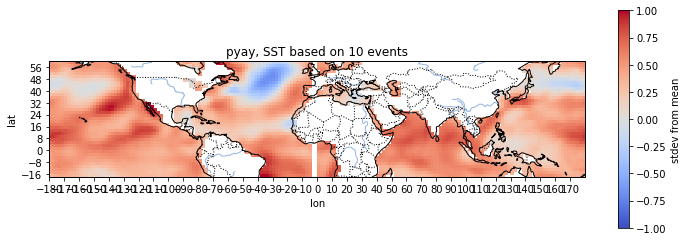

In [19]:
lat_start = 60
lat_end = -20
lon_start = 360 - 360
lon_end = 360 - 0

for loc in s_flood.keys():
    
    vm.sst_anomaly_plot(lat_start, lat_end, lon_start, lon_end, data_package['lat'], 
                        data_package['lon'], s_flood[loc], 
                        loc + ', SST based on ' +str(len(riv_dates)) + ' events', True)

#### Visualize one specific flood event 

In [15]:
riv_time_ind

,pyay
0,1447
1,1951
2,1807
3,1806
4,1939
5,1352
6,1725
7,1470
8,1412
9,1435


In [16]:
s_data_package['nc_vars']['sst'].shape

(1994, 89, 180)

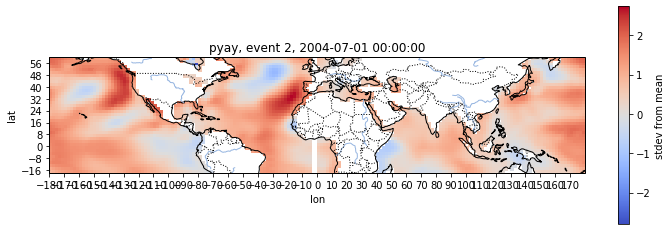

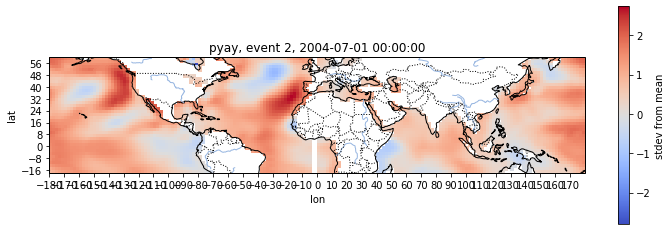

In [20]:
loc = 'pyay'
i = 2
ind = int(riv_time_ind['pyay'][i])
ind = ind - 1
temp = copy.deepcopy(s_data_package)
temp['sst'] = temp['nc_vars']['sst'][ind, :, :]

vm.sst_anomaly_plot(lat_start, lat_end, lon_start, lon_end, data_package['lat'], data_package['lon'], temp, loc + ', event ' +str(i) + ', ' + str(s_data_package['time'][ind]), False)